# World Bank Text Analytics Tutorial
### Patrick van Kessel
#### Senior Data Scientist, Pew Research Center

I adapted this notebook from a workshop I did in 2018 with an old colleague of mine, Michael Jugovich (now at IBM), for the New York chapter of the American Association for Public Opinion Research. The original repository can be found here: https://github.com/jugovich/NYAAPOR-Text-Analysis-2018 

## Loading in the data

We'll use a sample from the Kaggle Amazon Fine Food Reviews dataset. The full dataset can be found here: https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [0]:
import pandas as pd

In [0]:
sample = pd.read_csv("https://raw.githubusercontent.com/patrickvankessel/WorldBank-Text-Analysis-2019/master/kaggle_sample.csv")

In [3]:
print(len(sample))

10000


Let's see what's in here.

In [4]:
sample.head()

,Unnamed: 0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,467510,467511,B003WECB5S,A2G0LDLGXKQFYP,behrlekidsmom,2,2,3,1304640000,Holes in wrappers,The kids said the taste/flavor is fine but A L...
1,1,291775,291776,B000FVYUFA,A34O5D0QRGV29N,a Dallas reader,1,1,5,1188432000,Absolutely the best!,How can something this good be good for you to...
2,2,180629,180630,B000CQBZQK,A3ER3V2E06DH7D,"A. K. Kaw ""AKK""",0,1,5,1247529600,Tea meant for a late evening,"I love Earl Grey Tea. I have tried Tazo, Twini..."
3,3,412055,412056,B000CQC05K,A39Y02EJ310WJR,"Tech Girl ""Wendy""",2,2,5,1236729600,"Full-flavored, delicious tea that you can drin...",This tea is so fruity and full-flavored that i...
4,4,139779,139780,B001BCXTGS,A1LC1NMRA1ZEDZ,M. Garcia,1,1,5,1244332800,My cat only eats this brand,My cat is not crazy about the snapper and shri...


### Examine the data

Run the cell below a few times, let's take a look at our text and see what it looks like.  Always take a look at your raw data.

In [5]:
sample.sample(10)['Text'].values

array(["This is the only tea I have found that has a sharp orange flavor. It also has a mint flavor. I love drinking it when eating a chocolate desert. But it's good anytime. I love it.",
       "... I wished they didn't raise its price recently..<br />Now, it's cheaper to buy it at the store (around $7.69).",
       'I discovered this product while vacationing in Switzerland and have been addicted every since.  Unfortunately, stores rarely sell Toblerone at all and when they do, it is only the milk or dark chocolates.  The white has the smooth and creamy taste that is the best treat around.  All too often it seems Amazon is out of the white along with other on line vendors so when I see it, I stock up. I recommend you do the same.<br />Delicious!',
       'I used a combination of beans that included the Mexican beans to make homemade vanilla extract, vanilla sugar and vanilla Splenda. Everything came out great. The beans were fresh and very fragrant. The package arrived quickly and wi

### Preprocess the text (clean it up!)

I don't know about you, but I noticed some junk in our data - HTML and URLs.  Let's clear that out first.  We'll also take this opportunity to lemmatize the words - to do that, we'll install NLTK's WordNet library.

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
import re
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # First we'll use regular expressions to strip out links and HTML tags
    text = re.sub(r'http[a-zA-Z0-9\&\?\=\?\/\:\.]+\b', ' ', text)
    text = re.sub(r'\<[^\<\>]+\>', ' ', text)
    # Next, let's clear out all punctuation and replace it with whitespace
    text = re.sub(r'\W+', ' ', text) 
    # This isn't going to be perfect - ideally we expand contractions first
    # But it'll work well enough for now
    
    # Next, let's split on whitespace and then lemmatize each token
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(x) for x in tokens]
    text = " ".join(tokens)
  
    return text

sample['Text'] = sample['Text'].map(clean_text)

## TF-IDF Vectorization (Feature Extraction)

Just to be safe, let's add some additional words to a standard list of English stop words.

In [0]:
from sklearn.feature_extraction import stop_words as sklearn_stop_words
stop_words = set(sklearn_stop_words.ENGLISH_STOP_WORDS).union(set([
    "www", "http", "https", "br", "amazon", "href", "wa", "ha"
]))

Okay, now let's tokenize our text and turn it into numbers

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, 
    min_df=5, 
    ngram_range=(1, 1), 
    stop_words=stop_words, 
    max_features=2500
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

In [10]:
tfidf

<10000x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 252222 stored elements in Compressed Sparse Row format>

Because words are really big, by default we work with sparse matrices.  We can expand the sparse matrix with `.todense()` and compute sums like a normal dataframe.  Let's check out the top 20 words.

In [11]:
ngram_df = pd.DataFrame(tfidf.todense(), columns=ngrams) 
ngram_df.sum().sort_values(ascending=False)[:20]

like       321.212687
coffee     314.469860
good       307.319714
taste      300.116808
great      294.952329
tea        284.551104
product    280.683939
love       279.839847
flavor     276.754461
just       236.285851
food       208.878643
dog        203.022083
really     177.709624
price      174.029935
time       165.148894
buy        162.161193
make       161.857498
best       161.460087
cup        156.056577
bag        151.394981
dtype: float64

## Classification

Let's make an outcome variable.  How about we try to predict 5-star reviews, and then maybe helpfulness?

In [0]:
sample['good_score'] = sample['Score'].map(lambda x: 1 if x == 5 else 0)
sample['was_helpful'] = ((sample['HelpfulnessNumerator'] / sample['HelpfulnessDenominator']).fillna(0.0) > .80).astype(int)

In [0]:
column_to_predict = 'good_score'

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import metrics

results = []
kfolds = StratifiedKFold(n_splits=5)

We just created an object that'll split the data into fifths, and then iterate over it five times, holding out one-fifth each time for testing.  Let's do that now.  Each "fold" contains an index for training rows, and one for testing rows.  For each fold, we'll train a basic linear Support Vector Machine, and evaluate its performance.

In [15]:
for i, fold in enumerate(kfolds.split(tfidf, sample[column_to_predict])):
    
    train, test = fold 
    print("Running new fold, {} training cases, {} testing cases".format(len(train), len(test)))
    
    clf = svm.LinearSVC(
        max_iter=1000,
        penalty='l2',
        class_weight='balanced',
        loss='squared_hinge'
    )
    # We picked some decent starting parameters, but encourage you to try out different ones
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html 
    # If you're ambitious - check out the Scikit-Learn documentation and test out different models
    # http://scikit-learn.org/stable/supervised_learning.html
    
    training_text = tfidf[train]
    training_outcomes = sample[column_to_predict].loc[train]
    clf.fit(training_text, training_outcomes) # Train the classifier on the training data
    
    test_text = tfidf[test]
    test_outcomes = sample[column_to_predict].loc[test]
    predictions = clf.predict(test_text) # Get predictions for the test data
    
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(
        test_outcomes, # Compare the predictions against the true outcomes
        predictions
    )
    
    results.append({
        "fold": i,
        "outcome": 0,
        "precision": precision[0],
        "recall": recall[0],
        "fscore": fscore[0],
        "support": support[0]
    })
    
    results.append({
        "fold": i,
        "outcome": 1,
        "precision": precision[1],
        "recall": recall[1],
        "fscore": fscore[1],
        "support": support[1]
    })
    
results = pd.DataFrame(results)

Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases


How'd we do?

In [16]:
print(results.groupby("outcome").mean()[['precision', 'recall']])
print(results.groupby("outcome").std()[['precision', 'recall']])

         precision    recall
outcome                     
0         0.639631  0.698769
1         0.816753  0.773207
         precision    recall
outcome                     
0         0.009594  0.014841
1         0.007677  0.007380


Now we know that our model is pretty stable and reasonably performant, we can fit and transform the full dataset.

In [17]:
clf.fit(tfidf, sample[column_to_predict])  
print(metrics.classification_report(sample[column_to_predict].loc[test], predictions))
print(metrics.confusion_matrix(sample[column_to_predict].loc[test], predictions))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       731
           1       0.82      0.76      0.79      1269

    accuracy                           0.74      2000
   macro avg       0.73      0.74      0.73      2000
weighted avg       0.75      0.74      0.75      2000

[[520 211]
 [299 970]]


And now we can see what the most predictive features are.

In [18]:
import numpy as np

ngram_coefs = sorted(zip(ngrams, clf.coef_[0]), key=lambda x: x[1], reverse=True)
ngram_coefs[:10]

[('highly', 3.0801010314212443),
 ('best', 2.478795765756456),
 ('perfect', 2.322106159730798),
 ('love', 2.2412785832856583),
 ('favorite', 2.109231370790243),
 ('wonderful', 2.0524948600152095),
 ('addicted', 1.9452844749019707),
 ('fabulous', 1.907321893646624),
 ('european', 1.8736314725442462),
 ('cancer', 1.849459527930436)]

What happens if you change the outcome column to "was_helpful" and re-run it again?  Can you think of ways to improve this?  Add stopwords?  Bigrams?

## Topic Modeling

In [0]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [0]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #{}: {}".format(
            topic_idx,
            ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        ))

Let's find some topics.  We'll check out non-negative matrix factorization (NMF) first.

In [21]:
nmf = NMF(n_components=10, random_state=42, alpha=.1, l1_ratio=.5).fit(tfidf)
# Try out different numbers of topics (change n_components)
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
print("\nTopics in NMF model:")
print_top_words(nmf, ngrams, 10)


Topics in NMF model:
Topic #0: like, taste, flavor, just, really, don, sugar, water, ve, tried
Topic #1: coffee, cup, strong, roast, bold, flavor, blend, keurig, dark, like
Topic #2: tea, green, bag, drink, cup, iced, stash, black, earl, taste
Topic #3: dog, treat, love, food, chew, small, bone, teeth, size, training
Topic #4: cat, food, eat, dry, wellness, canned, chicken, ingredient, love, vet
Topic #5: product, store, price, order, buy, local, time, grocery, shipping, box
Topic #6: great, love, snack, price, deal, healthy, taste, recommend, highly, tasting
Topic #7: chocolate, bar, dark, peanut, candy, snack, nut, protein, butter, sweet
Topic #8: chip, bag, salt, potato, kettle, vinegar, snack, salty, flavor, fat
Topic #9: good, really, price, pretty, taste, quality, tasting, fresh, quite, enjoy


LDA is an other popular topic modeling technique

In [22]:
lda = LatentDirichletAllocation(n_components=10, random_state=42).fit(tfidf)
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
# doc_topic_prior (alpha) - lower alpha means documents will be composed of fewer topics (higher means a more uniform distriution across all topics)
# topic_word_prior (beta) - lower beta means topis will be composed of fewer words (higher means a more uniform distribution across all words)
print("\nTopics in LDA model:")
print_top_words(lda, ngrams, 10)


Topics in LDA model:
Topic #0: price, store, great, product, buy, shipping, local, good, grocery, love
Topic #1: dog, treat, chew, love, toy, bone, pill, teeth, formula, training
Topic #2: coffee, tea, cup, green, flavor, taste, like, strong, bold, love
Topic #3: bar, taste, snack, like, great, good, flavor, love, chocolate, chip
Topic #4: chip, grey, earl, popchips, chocolate, tea, white, pork, best, popcorn
Topic #5: sauce, noodle, hot, soup, spicy, chicken, seasoning, love, good, dish
Topic #6: product, like, tea, taste, just, good, flavor, bag, time, great
Topic #7: food, cat, dog, love, treat, eat, product, chicken, dry, pet
Topic #8: coffee, cup, tea, flavor, taste, like, good, drink, great, strong
Topic #9: pasta, taste, cheese, like, product, bread, good, tasted, great, pretzel


We can use the topic models the same way we did our classifier - everything in Scikit-Learn follows the same fit/transform paradigm.  So, let's get the topics for our documents.

In [0]:
doc_topics = pd.DataFrame(lda.transform(tfidf))

In [24]:
doc_topics.head()

,0,1,2,3,4,5,6,7,8,9
0,0.024094,0.024093,0.024093,0.024096,0.024090,0.143610,0.663642,0.024092,0.024093,0.024097
1,0.027766,0.027764,0.750106,0.027766,0.027758,0.027765,0.027777,0.027767,0.027765,0.027766
2,0.016932,0.016934,0.016940,0.016934,0.307188,0.016932,0.557335,0.016933,0.016940,0.016932
3,0.023148,0.023145,0.464586,0.023153,0.023142,0.023145,0.023148,0.023147,0.350240,0.023145
4,0.021644,0.021646,0.021646,0.021650,0.021642,0.021649,0.021649,0.587271,0.021645,0.239559


In [0]:
topic_column_names = ["topic_{}".format(c) for c in doc_topics.columns]
doc_topics.columns = topic_column_names

Next we use Pandas to join the topics with the original sample dataframe

In [0]:
sample_with_topics = pd.concat([sample, doc_topics], axis=1)

Let's look for patterns by running some means and correlations

In [27]:
sample_with_topics.groupby("Score").mean()

,Unnamed: 0,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time,good_score,was_helpful,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
Score,,,,,,,,,,,,,,,,,,
1,5036.623794,281326.536977,281327.536977,2.732047,4.827438,1.301871e+09,0.0,0.246517,0.045194,0.075199,0.064127,0.100845,0.027501,0.029671,0.490829,0.072687,0.054970,0.038978
2,4924.106618,285946.678309,285947.678309,1.795956,2.941176,1.301432e+09,0.0,0.216912,0.052027,0.057696,0.071686,0.179305,0.025980,0.037284,0.377767,0.064473,0.087966,0.045816
3,5035.062420,284394.638217,284395.638217,1.661146,2.369427,1.304282e+09,0.0,0.275159,0.055121,0.058776,0.080407,0.176994,0.025659,0.032307,0.351063,0.071218,0.114434,0.034021
4,4977.954056,280494.572146,280495.572146,1.274946,1.557071,1.296387e+09,0.0,0.320172,0.063491,0.052098,0.090695,0.202777,0.026693,0.043134,0.310917,0.068113,0.108298,0.033784
5,5000.835619,286496.501182,286497.501182,1.563278,1.762648,1.292853e+09,1.0,0.391962,0.087117,0.060335,0.085360,0.205422,0.030557,0.046969,0.265030,0.092680,0.089544,0.036986


In [28]:
for topic in topic_column_names:
    print("{}: {}".format(topic, sample_with_topics[topic].corr(sample_with_topics['Score'])))

topic_0: 0.09057467972739268
topic_1: -0.01960945176482254
topic_2: 0.03272564269106118
topic_3: 0.09310035155250233
topic_4: 0.023547152999123997
topic_5: 0.056220024146283236
topic_6: -0.1972726044480822
topic_7: 0.04712487342416328
topic_8: 0.029392534418780994
topic_9: -0.01027353589334897


Here's an example of a linear regression

In [29]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

training_data = sample_with_topics[topic_column_names[:-1]] # We're leaving a column out to prevent multicollinearity

regression = linear_model.LinearRegression()

# Train the model using the training sets
regression.fit(training_data, sample_with_topics['Score'])
coefficients = regression.coef_
for topic, coef in zip(topic_column_names[:-1], coefficients):
  print("{}: {}".format(topic, coef))

topic_0: 0.8510971153838108
topic_1: 0.029369807250430147
topic_2: 0.4264011587663883
topic_3: 0.5430934041571058
topic_4: 0.5423901852913203
topic_5: 0.9001330001162867
topic_6: -0.25980997865674704
topic_7: 0.5483580339434101
topic_8: 0.4090444157982454


Sadly Scikit-Learn doesn't make it easy to get p-values or a regression report like you'd normally expect of something like R or Stata.  Scikit-Learn is more about prediction than statistical analysis; for the latter, we can use Statsmodels.  

In [30]:
import statsmodels.api as sm

regression = sm.OLS(sample_with_topics['Score'], training_data)
results = regression.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                          1.063e+04
Date:                Wed, 17 Jul 2019   Prob (F-statistic):                        0.00
Time:                        16:38:48   Log-Likelihood:                         -17145.
No. Observations:               10000   AIC:                                  3.431e+04
Df Residuals:                    9991   BIC:                                  3.437e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Clustering

We can also check out other unsupervised methods like clustering.  I borrowed/modified some of this code from http://brandonrose.org/clustering

### K-Means Clustering

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, max_iter=50, tol=.01)
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans.fit(tfidf)
clusters = kmeans.labels_.tolist() # You can merge these back into the data if you want

In [32]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 
for i, closest_ngrams in enumerate(centroids):
    print("Cluster #{}: {}".format(i, np.array(ngrams)[closest_ngrams[:8]]))

Cluster #0: ['product' 'price' 'great' 'store' 'order' 'good' 'box' 'time']
Cluster #1: ['cat' 'food' 'eat' 'love' 'treat' 'wellness' 'chicken' 'dry']
Cluster #2: ['taste' 'like' 'good' 'love' 'just' 'great' 'sugar' 'make']
Cluster #3: ['tea' 'green' 'taste' 'drink' 'bag' 'flavor' 'good' 'like']
Cluster #4: ['bar' 'chocolate' 'snack' 'like' 'taste' 'protein' 'nut' 'good']
Cluster #5: ['chip' 'potato' 'bag' 'flavor' 'kettle' 'salt' 'like' 'love']
Cluster #6: ['flavor' 'sauce' 'great' 'good' 'like' 'salt' 'oil' 'popcorn']
Cluster #7: ['coffee' 'cup' 'like' 'flavor' 'strong' 'good' 'roast' 'taste']
Cluster #8: ['dog' 'treat' 'food' 'love' 'chew' 'like' 'product' 'good']
Cluster #9: ['chocolate' 'dark' 'cooky' 'taste' 'hot' 'like' 'good' 'flavor']


### Agglomerative/Hierarchical Clustering

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

We're going to characterize how similar words are to each other, based on their co-occurrence within documents. To keep things manageable, we'll use a smaller set of 500 words.

In [0]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, 
    min_df=5, 
    ngram_range=(1, 1), 
    stop_words=stop_words, 
    max_features=500
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

In [0]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

# Uses cosine similarity to get word similarities based on document overlap
# To get this for document similarities in terms of word overlap, just drop the .transpose()!
similarities = cosine_similarity(tfidf.transpose()) 
distances = 1 - similarities # Converts to distances
clusters = linkage(distances, method='ward') # Run hierarchical clustering on the distances

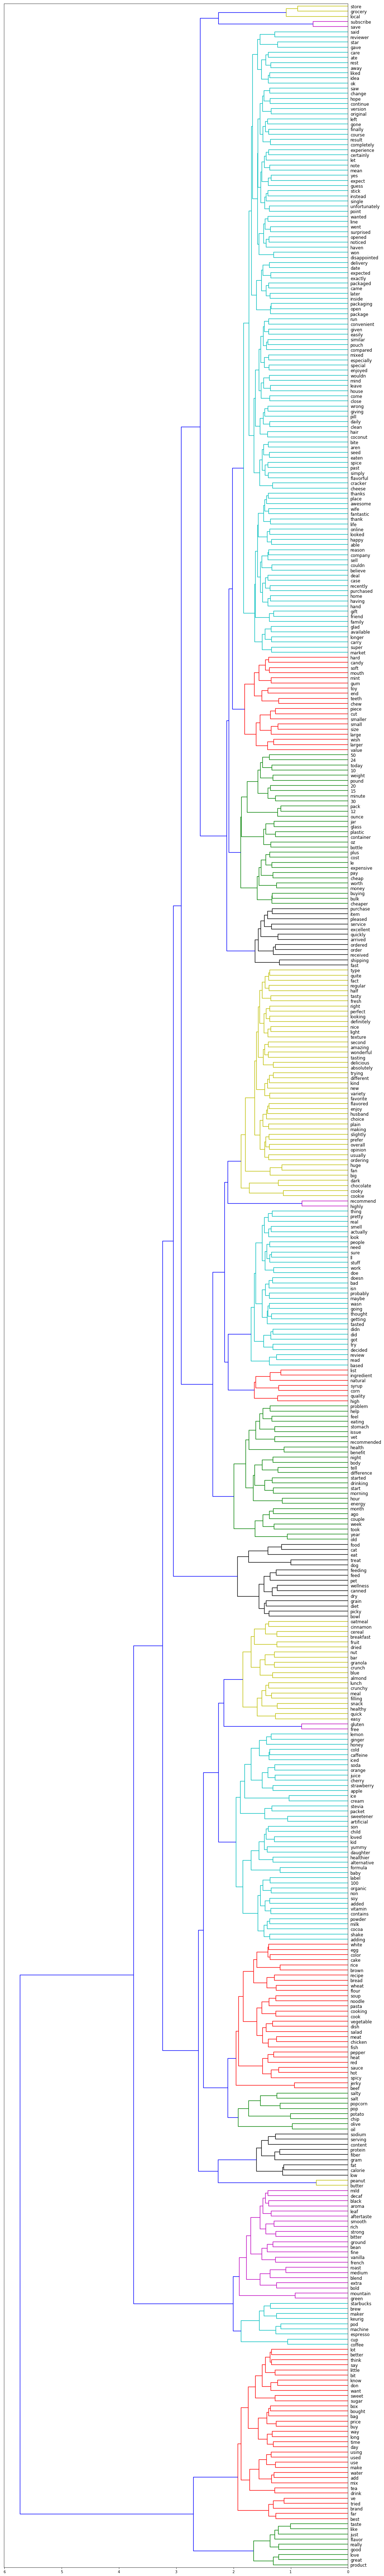

In [36]:
fig, ax = plt.subplots(figsize=(15, 100))
ax = dendrogram(clusters, labels=ngrams, orientation="left", leaf_font_size=12, color_threshold=2.0)
plt.tight_layout()